#**How do Face Datasets Inform Attractiveness**
#### Jingxing Fang, Aditi Memani, Hari Raval
#### AC 221
#### Group 10

# Set-up and Imports

In [ ]:
! pip install tensorflow_addons
! pip install tensorflow_datasets

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
# import statements
from google.colab import drive
import os
import zipfile
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import tqdm
%matplotlib inline

In [ ]:
# mount to google drive
drive.mount('drive/')
os.chdir("drive/Shared drives/AC 221 Final project/")

Mounted at drive/


In [ ]:
# enable eager execution of tensorflow

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Available GPUs: 
[]



# Load in the Data and Build Attributes Dataframe

In [ ]:
# load in the celebA data
gcs_base_dir = "gs://celeb_a_dataset/"
celeb_a_builder = tfds.builder("celeb_a", data_dir=gcs_base_dir, version='2.0.0')
celeb_a_builder.download_and_prepare()

num_test_shards_dict = {'0.3.0': 4, '2.0.0': 2}
version = str(celeb_a_builder.info.version)
print('Celeb_A dataset version: %s' % version)

# split into train, validation, and test datasets
train_celeb, valid_celeb, test_celeb = celeb_a_builder.as_dataset(split=['train', 'validation', 'test'], shuffle_files=True)

# load in the CSV file of attribute specific information associated with each image
celeb_attributes = pd.read_csv('data/list_attr_celeba.csv')
celeb_attribute_names = celeb_attributes.columns[1:]

# train, validation, and test sizes from https://www.tensorflow.org/datasets/catalog/celeb_a
train_size, valid_size, test_size = 162770, 19867, 19962

Celeb_A dataset version: 2.0.0


In [ ]:
# function to build an attribute table of metadata associated with each image for an inputted dataframe 
def build_attribute_table(df, size_to_use, celeb_attribute_names):
  # build a dictionary of attribute information across all training samples
  celeb_samples = df.take(size_to_use)
  celeb_attributes_dict = {} 
  # iterate over all training samples and append information to the appropriate attribute lists
  for i in celeb_samples:
    for name in celeb_attribute_names:
      if name not in celeb_attributes_dict:
        celeb_attributes_dict[name] = [i['attributes'][name].numpy()]
      else:
        celeb_attributes_dict[name].append(i['attributes'][name].numpy())
  
  return 1 * pd.DataFrame.from_dict(celeb_attributes_dict, orient='index').transpose()

# convert the train dictionary into a pandas dataframe for ease of exploratory data analysis 
train_attribute_values =  build_attribute_table(train_celeb, train_size, celeb_attribute_names)

# Exploratory Data Analysis 

In [ ]:
# view the first few rows of the train attribute data
train_attribute_values.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,1,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,1
3,1,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,1,1,0,0,0,1,0,0,...,1,1,1,0,0,0,0,0,0,0


In [ ]:
# output the train attribute summary statistic
train_attribute_values.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,...,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000,162770.000000
mean,0.111673,0.265884,0.513627,0.204460,0.022811,0.151656,0.240910,0.235553,0.239024,0.149088,...,0.056251,0.479695,0.208558,0.319359,0.186533,0.049389,0.469601,0.121423,0.073048,0.778940
std,0.314965,0.441804,0.499816,0.403308,0.149302,0.358688,0.427637,0.424345,0.426489,0.356176,...,0.230407,0.499589,0.406279,0.466230,0.389537,0.216679,0.499077,0.326619,0.260216,0.414962
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# create a set of columns that will be used to plot a combination of two features: (age and gender), (age and double chin), (age and chubby), and (age and blonde)
train_attribute_values['age_gender_combo'] = train_attribute_values['Young'].astype(str) + train_attribute_values['Male'].astype(str)
train_attribute_values['age_chin_combo'] = train_attribute_values['Young'].astype(str) + train_attribute_values['Double_Chin'].astype(str)
train_attribute_values['age_chubby_combo'] = train_attribute_values['Young'].astype(str) + train_attribute_values['Chubby'].astype(str)
train_attribute_values['age_Blonde_combo'] = train_attribute_values['Young'].astype(str) + train_attribute_values['Blond_Hair'].astype(str)

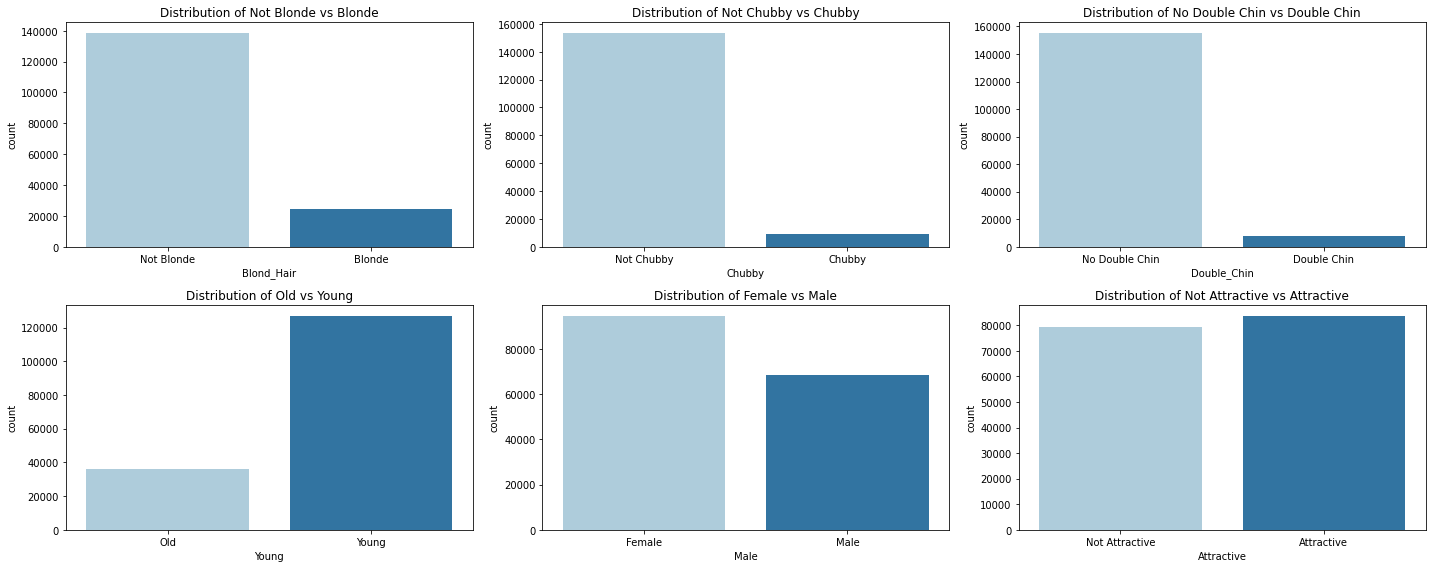

In [ ]:
# generate plots of the counts of the attributes of interest: blonde hair, chubbiness, double chin, young, male, and attractive
fig, axs = plt.subplots(2,3, figsize=(20,8))

# attributes to plot
attributes_of_interest = ['Blond_Hair', "Chubby", "Double_Chin", "Young", "Male", "Attractive"]

# labels per plot
labels = [['Not Blonde', "Blonde"], ["Not Chubby", "Chubby"] ,["No Double Chin", "Double Chin"], ["Old", "Young"], ["Female", "Male"], ["Not Attractive", "Attractive"]]

# generate each plot in a grid
for attribute, label, ax in zip(attributes_of_interest, labels, axs.ravel()):
  plot = sns.countplot(x=attribute, data=train_attribute_values, ax=ax, palette=sns.color_palette("Paired"));
  ax.set_xticklabels(label)
  ax.set_xlabel(f"{attribute}")
  ax.set_title(f"Distribution of {label[0]} vs {label[1]}")

plt.tight_layout();

We analyzed the absolute distributions for six key attributes that displayed large disparities between their sub-groups. Due to their uneven distribution, we will also focus on the error rates of the results, while developing our models. Specifically, we focused on understanding the uneven distribution of the training dataset since this is the dataset that the model will be trained on. Therefore, the biases that originate in the training data can lead to algorithmic biases when designing the model.  We clearly see that for every attribute, except for Attractiveness (our model's predicted result), one can see distinct representation biases within each category, which could then lead to results with high error rates for the underrepresented groups. For example, if we examine the distribution for age, we see that over 77% are images of younger individuals, this will result in systematically producing more positive results for the young compared to the old and produce a significantly higher FPR for the ‘Young’ and a significantly higher FNR for the ‘Old’. We see similar overrepresentation for individuals that are Not Blonde (85%), Not Chubby (94%), No Double Chin (95%), and Female (58%), which will then be compounded in the model and lead to significant error results.



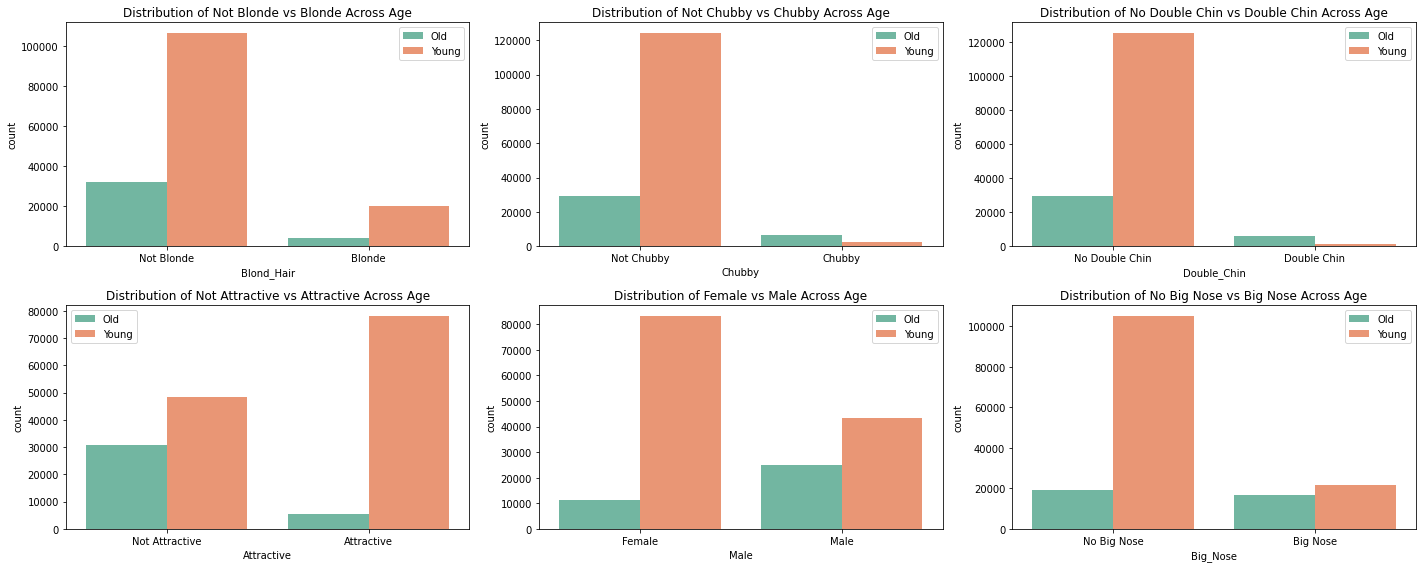

In [ ]:
# generate plots of the distribution of each feature of interest across age
fig, axs = plt.subplots(2,3, figsize=(20,8))

# attributes to plot 
attributes_of_interest = ['Blond_Hair', "Chubby", "Double_Chin", "Attractive", "Male", "Big_Nose"]

# labels per plot
labels = [['Not Blonde', "Blonde"], ["Not Chubby", "Chubby"] ,["No Double Chin", "Double Chin"], ["Not Attractive", "Attractive"], ["Female", "Male"], ["No Big Nose", "Big Nose"]]

# generate each plot in a grid
for attribute, label, ax in zip(attributes_of_interest, labels, axs.ravel()):
  sns.countplot(x=attribute, data=train_attribute_values, hue = 'Young', ax=ax, palette=sns.color_palette("Set2"));
  ax.set_xticklabels(label)
  ax.set_xlabel(f"{attribute}")
  ax.set_title(f"Distribution of {label[0]} vs {label[1]} Across Age")
  ax.legend(labels=['Old', 'Young'])

plt.tight_layout();

As illustrated above, the disparity between the 'Young' and the 'Old' was extremely significant and we wanted to understand how this would impact the analysis of cross-sectional distributions ​​across age. Similarly, we saw that any sub-category combined with the label 'Young' was systematically overrepresented. For example, 88% of the females are young and 63% of the males are young. We can easily see there is a significant representation bias against the Old & Female and Old & Male in our training dataset, and therefore there is a high likelihood that this type of bias will seep into our model and skew the results in favor of the Young & Female and Young & Male. When we analyze the disparity between the Young & Female and Young & Male, we see that the overrepresentation of Female further augments the representation bias we see with the 'Young'. We will need to keep this in mind when we conduct cross-sectional analyses of the results across age in our Discussion section.


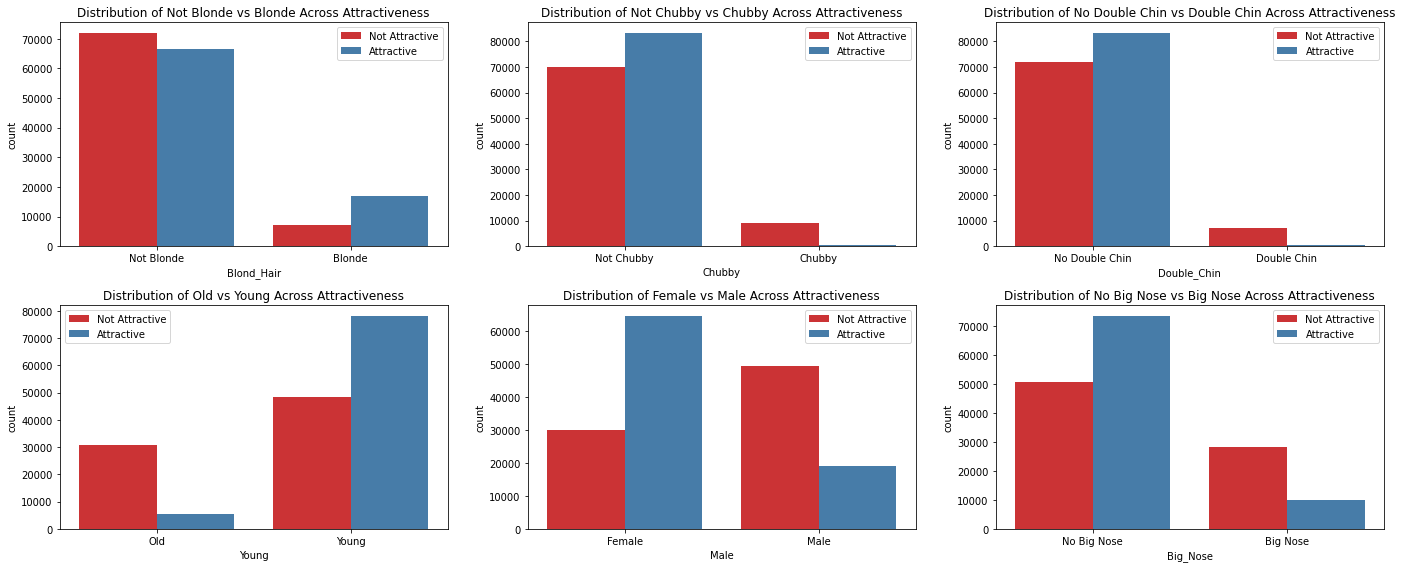

In [ ]:
# generate plots of the distribution of each feature of interest across attractiveness feature
fig, axs = plt.subplots(2,3, figsize=(20,8))

# attributes to plot
attributes_of_interest = ['Blond_Hair', "Chubby", "Double_Chin", "Young", "Male", "Big_Nose"]

# labels per plot
labels = [['Not Blonde', "Blonde"], ["Not Chubby", "Chubby"] ,["No Double Chin", "Double Chin"], ["Old", "Young"], ["Female", "Male"], ["No Big Nose", "Big Nose"]]

# generate each plot in a grid
for attribute, label, ax in zip(attributes_of_interest, labels, axs.ravel()):
  sns.countplot(x=attribute, data=train_attribute_values, hue = 'Attractive', ax=ax, palette=sns.color_palette("Set1"));
  ax.set_xticklabels(label)
  ax.set_xlabel(f"{attribute}")
  ax.set_title(f"Distribution of {label[0]} vs {label[1]} Across Attractiveness")
  ax.legend(labels=['Not Attractive', 'Attractive'])

plt.tight_layout();

We analyzed the distributions for six attributes across attractiveness, since this is the key attribute we will be predicting using our model. By understanding the distribution of attributes across attractiveness, we can see if there are even further representation biases that exist in our training dataset, and therefore can influence our model. We saw a range of disparities within each attribute when the individuals were categorized as attractive (1) or unattractive (0). For example, the distribution of 'Blonde Hair' attribute across attractiveness were somewhat even for each subgroup, yet there was a huge disparity regarding the distribution of age and gender across attractiveness. Such imbalances in the dataset across the key attribute we are looking to predict can cause extremely disproportionate results in favor of one subgroup over another, which again could further inflame possible existing algorithmic biases that exist while using a neural network.


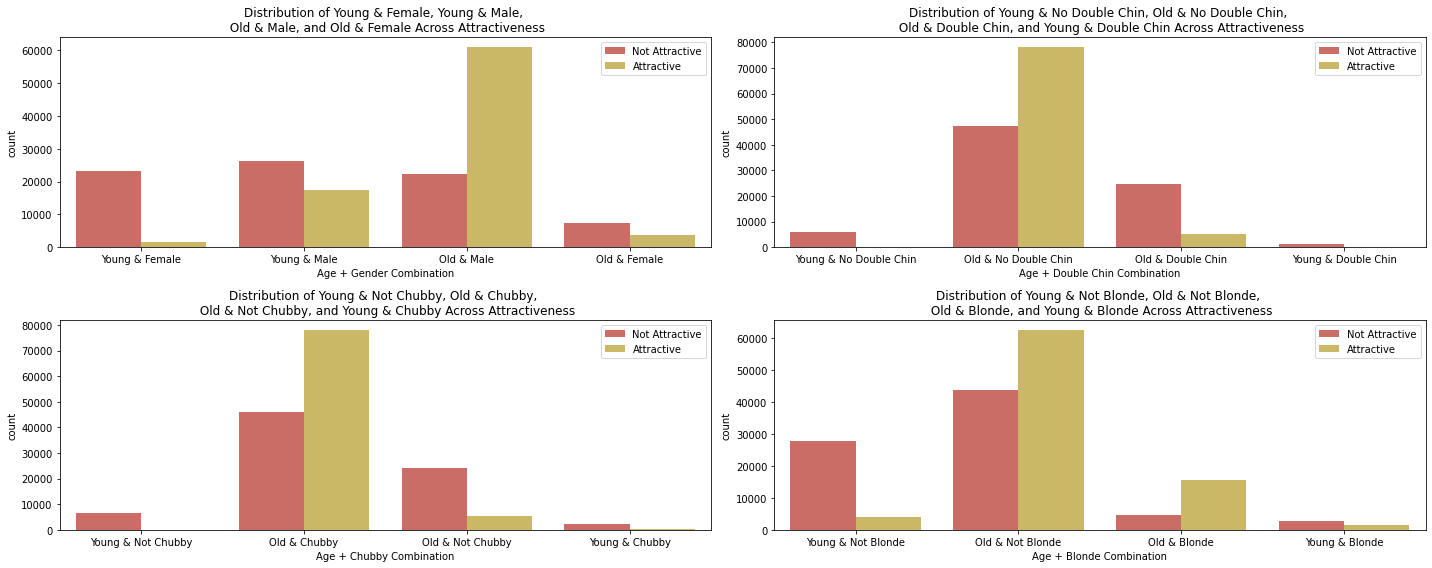

In [ ]:
# list of combined feature columns to stratify against
age_combo_columns = ['age_gender_combo', 'age_chin_combo','age_chubby_combo', 'age_Blonde_combo']


# labels per plot
labels = [["Young & Female", "Young & Male", "Old & Male", "Old & Female"], ["Young & No Double Chin", "Old & No Double Chin", "Old & Double Chin", "Young & Double Chin"], 
          ["Young & Not Chubby", "Old & Chubby",  "Old & Not Chubby", "Young & Chubby"], ["Young & Not Blonde", "Old & Not Blonde",  "Old & Blonde", "Young & Blonde"]]

x_axis_labels = ['Age + Gender Combination', 'Age + Double Chin Combination', 'Age + Chubby Combination', 'Age + Blonde Combination']
# generate plots of the distribution of each feature of interest across attractiveness feature
fig, axs = plt.subplots(2,2, figsize=(20,8))

for combo_col, ax, xlab, lab in zip(age_combo_columns, axs.ravel(), x_axis_labels, labels):
  sns.countplot(x = train_attribute_values[combo_col], data=train_attribute_values, hue='Attractive', ax=ax, palette=sns.color_palette("hls", 8))
  ax.set_xticklabels(lab)
  ax.set_xlabel(f"{xlab}")
  ax.legend(labels=['Not Attractive', 'Attractive'])
  ax.set_title(f"Distribution of {lab[0]}, {lab[1]}, \n {lab[2]}, and {lab[3]} Across Attractiveness")

plt.tight_layout();

We wanted to see if there were any interesting patterns within the cross-sectional distributions of two key attributes across attractiveness. We expected that the representation bias we saw earlier would be further exacerbated when combining two attributes that already have a significantly uneven absolute distribution. Our expectations were confirmed, especially when analyzing age combined with another attribute, specifically focusing on the combined subgroups with the label 'Young'. For example, when we combined age and gender, we saw a disproportionately high number of individuals that were labeled attractive. Namely, we found that 72% of attractive individuals were young females, while only 4% of attractive individuals were old females. Such disparities can indicate a certain link between the two attributes and how their combined subgroups can cause algorithmic bias which can result in extremely unfavorable outcomes, and in this dataset, this especially holds true for those labeled old female or old male.

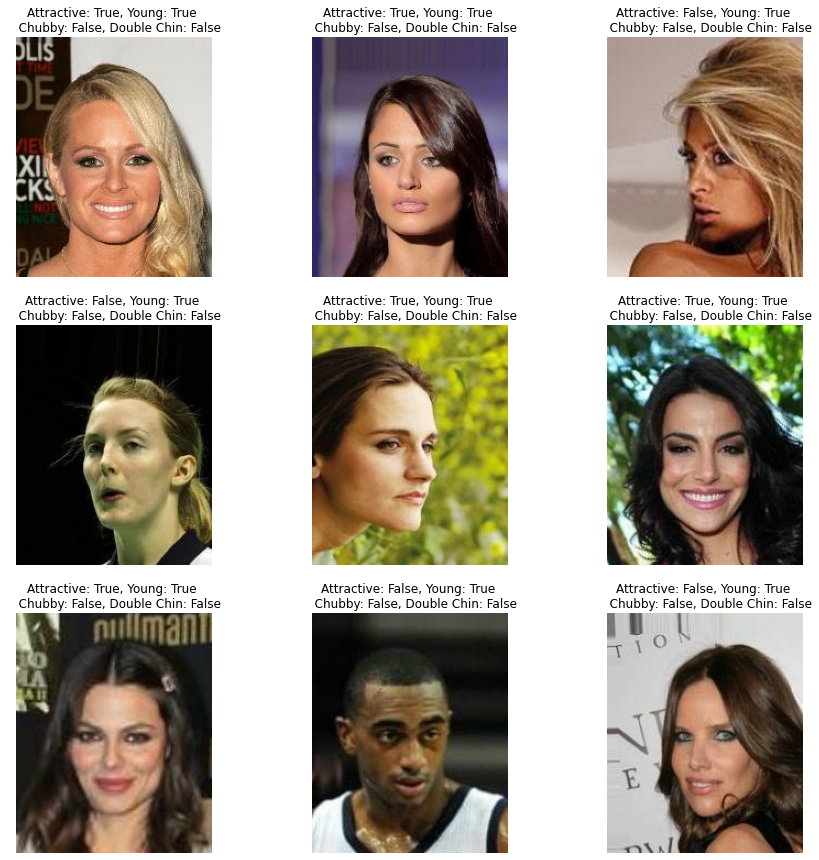

In [ ]:
# output a few images from the dataset to ensure images loaded in properly
# extract 4 tuples consisting of (image, label)
train_celeb_small_subset = train_celeb.take(9)

# create a grid of subplots to place 9 images in 
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# iterate over the nine images with their rotated labels
for ax, tf_obj in zip(ax.ravel(), train_celeb_small_subset):
  ax.imshow(tf_obj['image'])
  ax.set_title(f"Attractive: {tf_obj['attributes']['Attractive']}, Young: {tf_obj['attributes']['Young']} \n \
  Chubby: {tf_obj['attributes']['Chubby']}, Double Chin: {tf_obj['attributes']['Double_Chin']}")
  ax.axis('off')

# Model Design and Training 

In [ ]:
# function to prepare the data for model input
def get_attractive(elem):
    # normalize the data 
    return (tf.cast(elem['image'],dtype=tf.float32)/255., tf.cast(elem['attributes']['Attractive'],dtype=tf.int16))

# prepare the train, validation, and test data
train_data = train_celeb.map(get_attractive)
valid_data = valid_celeb.map(get_attractive)
test_data = test_celeb.map(get_attractive)

In [ ]:
# define a CNN to train the data with 

# make use of the Keras Sequential API 
model_b = Sequential(name="bgcnn")

# add a convolutional layer with batch normalization
model_b.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(218, 178, 3), name="Conv_1"))
model_b.add(layers.BatchNormalization())

# add a convolutional layer with batch normalization and max pooling
model_b.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', name="Conv_2"))
model_b.add(layers.BatchNormalization())
model_b.add(layers.MaxPooling2D((3, 3), name="MaxPool_1"))

# add two convolutional layers with max pooling
model_b.add(layers.Conv2D(32, (3,   3), activation='relu', padding='same', name="Conv_3"))
model_b.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv_4"))
model_b.add(layers.MaxPooling2D((3, 3), name="MaxPool_2"))

# flatten the data before passing it to the fully connected layers
model_b.add(layers.Flatten(name="Flatten"))

# create the fully connected layers and add dropout 
model_b.add(layers.Dense(128, activation='relu', name="FullyConnected_0", kernel_regularizer='l2'))
model_b.add(layers.Dropout(0.5, name="Dropout_1"))
model_b.add(layers.Dense(64, activation='relu', name="FullyConnected_1", kernel_regularizer='l2'))

# sigmoid output layer due to the binary nature of the prediction 
model_b.add(layers.Dense(1, activation='sigmoid', name="Output"))

In [ ]:
# view the model summary 
model_b.summary()

Model: "bgcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 216, 176, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 216, 176, 8)      32        
 ormalization)                                                   
                                                                 
 Conv_2 (Conv2D)             (None, 216, 176, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 216, 176, 16)     64        
 hNormalization)                                                 
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 72, 58, 16)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 72, 58, 32)        4640  

In [ ]:
# compile and fit the model 
lr = 0.0001
batch_size = 128
epochs = 2
model_b.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

# NOTE: uncomment line below to fit model using 2 epochs (approx. time = 8 hrs.)
# model_b.fit(train_data.shuffle(buffer_size = 1000).batch(batch_size), epochs=epochs, validation_data=valid_data.batch(batch_size))

In [ ]:
# NOTE: save the model weights (again uncomment to save weights if retraining model)
# model_b.save('./model/save_model/model_b_e2')

### Model Limitations

While our model yields reasonable results for the problem we aimed to solve, we also acknowledge that convolutional neural networks (CNNs), and neural network models more generally, contain limitations. First, CNNs are limited in their ability to enable rapid analysis. Due to limited computational resources, our model is not complex enough to make full use of all the features in the CelebA dataset. In other words, our model does not contain as many convolutional layers and so we don’t extract as many features from the images due to the shallower network architecture. Next, CNNs are also limited by the data availability. For the CelebA dataset, we have access to only about 200,000 images which we must further split into train, validation, and testing datasets. More complex model architectures require millions of samples to train on and hence our model is limited by the data we can train it with.

Another key limitation of CNNs, and neural networks more generally, is the fact that they provide limited interpretability while training. In other words, it is not straightforward or obvious to understand what exactly our model has learned from the data and how different features are ranked. In this regard, understanding how dataset biases are carried over into a neural network is much more challenging to diagnose. Often, such dataset biases will become evident in the post-model analysis, at which point it is up to the data scientist to comprehend and address any such issues. This is a challenging task for neural networks which often have millions of trainable parameters. Other simpler models such as logistic regression and random forests excel at providing such interpretability and so dataset biases can potentially be more easily observed and addressed. 

Though CNNs have been shown to have near-human image recognition abilities, they are not able to learn from images in the same way as humans. Humans have a 3D understanding of objects, allowing them to correctly fill in the necessary depth information required to interpret such images. This information comes from intuition built from our life experiences in seeing 2D pictures of an object. CNNs are not able to accomplish this kind of higher-order task and are limited to the data directly provided to them. A CNN must be trained on many images of an object from different angles to understand different profiles. For example, in our task at hand, a human can judge the attractiveness of a person based on different perceptions of depth such as viewing the sharpness of a person’s nose or the fullness of one’s lips. Unfortunately, CNNs do not have the ability to obtain such detailed depth-specific information about 3D characteristics without multiple profiles of the same image. As a result of this limitation of CNN vision, they can be easily fooled by adversarial attacks. We can add some subtle noise to an image, which might be negligible to the human eye, but can cause the CNN to output vastly different results.

#Model Evaluation

In [ ]:
# to save on training time, load the weights of the model trained above 
model_b = tf.keras.models.load_model('./model/save_model/model_b_e2')

# compute the accuracy on the training and test set
print(f"CNN Model Train Accuracy for Attractiveness: {100 * model_b.evaluate(train_data.batch(64))[1]: .2f}%")
print()
print(f"CNN Model Test Accuracy for Attractiveness: {100 * model_b.evaluate(test_data.batch(64))[1]: .2f}%")

# convert the test dictionary into a pandas dataframe for ease of exploratory data analysis 
test_attribute_values =  build_attribute_table(test_celeb, test_size, celeb_attribute_names)

2544/2544 [==============================] - 2282s 896ms/step - loss: 0.5002 - accuracy: 0.8109
CNN Model Train Accuracy for Attractiveness:  81.09%

312/312 [==============================] - 285s 912ms/step - loss: 0.5046 - accuracy: 0.8061
CNN Model Test Accuracy for Attractiveness:  80.61%


In [ ]:
# build a baseline model that predicts the highest proportion of attractiveness (1 or 0) in the test data
def build_baseline_model(attribute_values):
  count_not_attractive = attribute_values.iloc[np.where(attribute_values['Attractive'] == 0)].shape[0]
  count_attractive = attribute_values.iloc[np.where(attribute_values['Attractive'] == 1)].shape[0]
  baseline = None

  # determine which subgroup is more common in the data and find the baseline accordingly 
  if count_not_attractive > count_attractive:
    assert count_not_attractive + count_attractive == attribute_values.shape[0]
    baseline = count_not_attractive / (count_not_attractive + count_attractive)
  else:
    assert count_not_attractive + count_attractive == attribute_values.shape[0]
    baseline = count_attractive / (count_not_attractive + count_attractive)

  return baseline

# output the baseline model accuracy for train data
baseline_model_train_result = build_baseline_model(train_attribute_values)
print(f"Baseline Model Train Accuracy for Attractiveness: {100 * baseline_model_train_result: .2f}%")
# output the baseline model accuracy for test data
baseline_model_test_result = build_baseline_model(test_attribute_values)
print(f"Baseline Model Test Accuracy for Attractiveness: {100 * baseline_model_test_result: .2f}%")

Baseline Model Train Accuracy for Attractiveness:  51.36%
Baseline Model Test Accuracy for Attractiveness:  50.42%


In [ ]:
# NOTE: this block takes 30 minutes to run, therefore we've outputted the results to a csv called test_attributes.csv for efficiency
# build a dictionary of attribute information across all test samples
# and generate corresponding prediction results

test_samples = test_celeb.take(test_size)
y_preds = []
test_attributes_dict = {} 
# iterate over all test samples and append to the appropriate attribute lists
for idx, i in enumerate(test_samples):
  img = tf.expand_dims(tf.cast(i['image'], dtype=tf.float32)/255., axis=0)
  y_pred = model_b.predict(img)[0][0]
  y_preds.append(y_pred)
  for name in celeb_attribute_names:
    if name not in test_attributes_dict:
      test_attributes_dict[name] = [i['attributes'][name].numpy()]
    else:
      test_attributes_dict[name].append(i['attributes'][name].numpy())
  

In [ ]:
# NOTE: Only run if you have changed and have run the previous block -- creates new test_attribute.csv file
test_attribute_values = 1 * pd.DataFrame.from_dict(test_attributes_dict, orient='index').transpose()
attractive_pred = np.where(np.array(y_preds)>=0.5, 1, 0)
test_attribute_values['Pred_attractive'] = attractive_pred
test_attribute_values.to_csv('./data/test_attributes.csv', index=False)

In [ ]:
# loads in the pre-existing test attributes 
test_attribute_values = pd.read_csv('./data/test_attributes.csv')
test_attribute_values.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,Pred_attractive
0,0,0,1,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,0,1,1
1,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,0,1,1


In [ ]:
# confirming that the test attributes obtained from the .csv file are accurate
test_attribute_values = pd.read_csv('./data/test_attributes.csv')
print(f'Test accuracy: {np.mean(test_attribute_values.Attractive==test_attribute_values.Pred_attractive)*100:.2f}%')

Test accuracy: 80.61%


### Post-Processing Model Results

In [ ]:
# create a set of columns that will be used to plot a combination of two features: (age and gender), (age and double chin), (age and chubby), and (age and blonde)
test_attribute_values['age_gender_combo'] = test_attribute_values['Young'].astype(str) + test_attribute_values['Male'].astype(str)
test_attribute_values['age_chin_combo'] = test_attribute_values['Young'].astype(str) + test_attribute_values['Double_Chin'].astype(str)
test_attribute_values['age_chubby_combo'] = test_attribute_values['Young'].astype(str) + test_attribute_values['Chubby'].astype(str)
test_attribute_values['age_Blonde_combo'] = test_attribute_values['Young'].astype(str) + test_attribute_values['Blond_Hair'].astype(str)

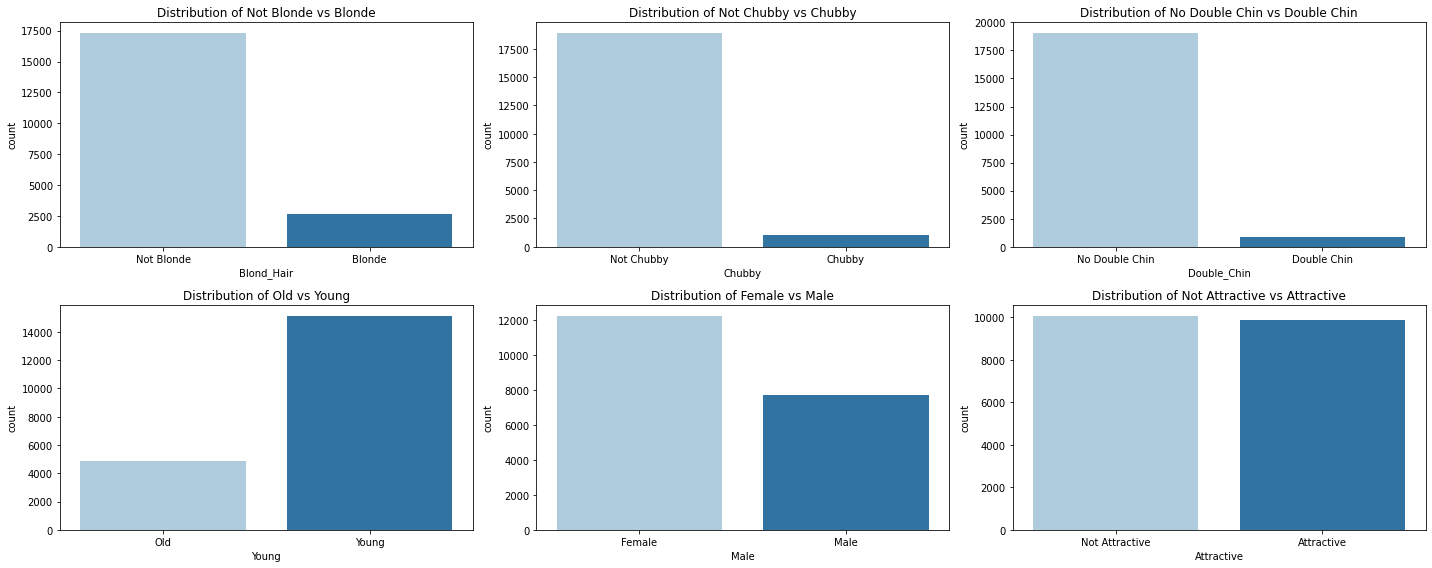

In [ ]:
# generate plots of the counts of the attributes of interest: blonde hair, chubbiness, double chin, young, male, and attractive
fig, axs = plt.subplots(2,3, figsize=(20,8))

# attributes to plot
attributes_of_interest = ['Blond_Hair', "Chubby", "Double_Chin", "Young", "Male", "Attractive"]

# labels per plot
labels = [['Not Blonde', "Blonde"], ["Not Chubby", "Chubby"] ,["No Double Chin", "Double Chin"], ["Old", "Young"], ["Female", "Male"], ["Not Attractive", "Attractive"]]

# generate each plot in a grid
for attribute, label, ax in zip(attributes_of_interest, labels, axs.ravel()):
  plot = sns.countplot(x=attribute, data=test_attribute_values, ax=ax, palette=sns.color_palette("Paired"));
  ax.set_xticklabels(label)
  ax.set_xlabel(f"{attribute}")
  ax.set_title(f"Distribution of {label[0]} vs {label[1]}")

plt.tight_layout();

In [ ]:
# creating dictionary of labels 
atonym = {
    'Young': 'Old', 'Male': 'Female', 'Blond_Hair': 'Not Blonde', 'Chubby': 'Not Chubby', "Double_Chin": 'No Double_Chin'
}
# create comparison tables of predicted vs. actual results for each analyzed category 
def contrast_cross_result(attr):
    df = pd.DataFrame({
        'Predicted': [np.mean(test_attribute_values.loc[test_attribute_values[attr]==1,'Pred_attractive']), 
          np.mean(test_attribute_values.loc[test_attribute_values[attr]==0,'Pred_attractive'])],
        'Actual': [np.mean(test_attribute_values.loc[test_attribute_values[attr]==1,'Attractive']), 
          np.mean(test_attribute_values.loc[test_attribute_values[attr]==0,'Attractive'])]
    }, index=[attr, atonym[attr]])
    return df

In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Young vs. Old 
contrast_cross_result('Young')

,Predicted,Actual
Young,0.599775,0.603149
Old,0.170380,0.161304


In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Male vs. Female
contrast_cross_result('Male') 

,Predicted,Actual
Male,0.178743,0.248088
Female,0.695027,0.651915


In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Blonde Hair vs. Not Blonde Hair
contrast_cross_result('Blond_Hair')

,Predicted,Actual
Blond_Hair,0.686466,0.653759
Not Blonde,0.466131,0.471564


In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Chubby vs. not Chubby
contrast_cross_result('Chubby')

,Predicted,Actual
Chubby,0.051040,0.029301
Not Chubby,0.520366,0.521953


In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Double Chin vs. No Double Chin
contrast_cross_result('Double_Chin') 

,Predicted,Actual
Double_Chin,0.044907,0.028478
No Double_Chin,0.517088,0.518242


In [ ]:
# creating a dictionary of cross sectional labels 
labels = {'age_gender_combo':{'10':"Young & Female", '11':"Young & Male", '01':"Old & Male", '00':"Old & Female"}, 
          'age_chin_combo':{'10':"Young & No Double Chin", '00': "Old & No Double Chin", '01': "Old & Double Chin", '11': "Young & Double Chin"}, 
          'age_chubby_combo': {'10': "Young & Not Chubby", '01': "Old & Chubby", '00': "Old & Not Chubby", '11': "Young & Chubby"}, 
          'age_Blonde_combo': {'10': "Young & Not Blonde", '00': "Old & Not Blonde", '01': "Old & Blonde", '11': "Young & Blonde"}}
          
# method to compare predicted vs. actual results of cross-sectional outputs
def contrast_cross_result_combined(df, attr):
    print(attr)
    data = dict()
    data['categories'] = ['00','01','10','11']
    data['labels'] = [ labels[attr][c] for c in data['categories'] ]
    data['Predicted'] = [ np.mean(df.loc[df[attr]==cat,'Pred_attractive']) for cat in data['categories']]
    data['Actual'] = [ np.mean(df.loc[df[attr]==cat,'Attractive']) for cat in data['categories']]
    return pd.DataFrame(data).drop(columns=['categories'])

In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Young/Old/Male/Female
contrast_cross_result_combined(test_attribute_values, 'age_gender_combo')

age_gender_combo


,labels,Predicted,Actual
0,Old & Female,0.405010,0.322025
1,Old & Male,0.017053,0.056276
2,Young & Female,0.748814,0.713097
3,Young & Male,0.277859,0.365670


In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Young/Old/Double Chin/No Double Chin
contrast_cross_result_combined(test_attribute_values, 'age_chin_combo')

age_chin_combo


,labels,Predicted,Actual
0,Old & No Double Chin,0.197132,0.186923
1,Old & Double Chin,0.020436,0.017711
2,Young & No Double Chin,0.605223,0.609508
3,Young & Double Chin,0.145251,0.072626


In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Young/Old/Chubby/Not Chubby
contrast_cross_result_combined(test_attribute_values, 'age_chubby_combo')

age_chubby_combo


,labels,Predicted,Actual
0,Old & Not Chubby,0.199703,0.190547
1,Old & Chubby,0.023544,0.014870
2,Young & Not Chubby,0.607549,0.612057
3,Young & Chubby,0.139442,0.075697


In [ ]:
# Investigate the proportion of being predicted attractive compared to the proportion of actually being attractive for Young/Old/Blonde Hair/Not Blonde
contrast_cross_result_combined(test_attribute_values, 'age_Blonde_combo')

age_Blonde_combo


,labels,Predicted,Actual
0,Old & Not Blonde,0.134755,0.134755
1,Old & Blonde,0.432014,0.356282
2,Young & Not Blonde,0.574607,0.581818
3,Young & Blonde,0.757576,0.736893


### Error Rate Analysis

In [ ]:
# method to compute false positive, false negative, accuracy, and true positive rates for a single attribute 
def show_accuracy_fpr_tpr(df, attr):
    index = ['acc', 'fpr', 'tpr', 'fnr']
    tn1, fp1, fn1, tp1 = confusion_matrix(df.loc[df[attr]==1,"Attractive"], df.loc[df[attr]==1,"Pred_attractive"]).ravel()
    tn0, fp0, fn0, tp0 = confusion_matrix(df.loc[df[attr]==0,"Attractive"], df.loc[df[attr]==0,"Pred_attractive"]).ravel()
    data = {
        attr: [np.mean(df.loc[df[attr]==1,"Attractive"] == df.loc[df[attr]==1,"Pred_attractive"]),fp1/(fp1+tn1), tp1/(fn1+tp1), fn1/(fn1+tp1)],
        atonym[attr]: [np.mean(df.loc[df[attr]==0,"Attractive"] == df.loc[df[attr]==0,"Pred_attractive"]),fp0/(fp0+tn0), tp0/(fn0+tp0), fn0/(fn0+tp0)]
    }
    return pd.DataFrame(data, index=index)

# method to compute false positive, false negative, accuracy, and true positive rates for two attributes
def show_accuracy_fpr_tpr_combined(df, attr):
    print(attr)
    index = ['acc', 'fpr', 'tpr', 'fnr']
    data = {}
    for cat in ['10','11','00','01']:
        tn, fp, fn, tp = confusion_matrix(df.loc[df[attr]==cat,"Attractive"], df.loc[df[attr]==cat,"Pred_attractive"]).ravel()
        data[labels[attr][cat]] = [np.mean(df.loc[df[attr]==cat,"Attractive"] == df.loc[df[attr]==cat,"Pred_attractive"]),fp/(fp+tn), tp/(fn+tp), fn/(fn+tp)]
    return pd.DataFrame(data, index=index)

In [ ]:
# false positive, false negative, accuracy, and true positive rates for Young/Old
show_accuracy_fpr_tpr(test_attribute_values, "Young")

,Young,Old
acc,0.784769,0.872525
fpr,0.266922,0.081407
tpr,0.818780,0.632992
fnr,0.181220,0.367008


In [ ]:
# false positive, false negative, accuracy, and true positive rates for Male/Female
show_accuracy_fpr_tpr(test_attribute_values, "Male")

,Male,Female
acc,0.823590,0.795052
fpr,0.071195,0.356322
tpr,0.504702,0.875877
fnr,0.495298,0.124123


In [ ]:
# false positive, false negative, accuracy, and true positive rates for Chubby/Not Chubby
show_accuracy_fpr_tpr(test_attribute_values, "Chubby")

,Chubby,Not Chubby
acc,0.948015,0.798138
fpr,0.037975,0.209472
tpr,0.483871,0.805108
fnr,0.516129,0.194892


In [ ]:
# false positive, false negative, accuracy, and true positive rates for Blonde Hair/Not Blonde
show_accuracy_fpr_tpr(test_attribute_values, "Blond_Hair")

,Blond_Hair,Not Blonde
acc,0.792105,0.808230
fpr,0.347448,0.176310
tpr,0.866015,0.790906
fnr,0.133985,0.209094


In [ ]:
# false positive, false negative, accuracy, and true positive rates for Double Chin/No Double Chin
show_accuracy_fpr_tpr(test_attribute_values, "Double_Chin")

,Double_Chin,No Double_Chin
acc,0.957284,0.798835
fpr,0.030440,0.207584
tpr,0.538462,0.804801
fnr,0.461538,0.195199


In [ ]:
# false positive, false negative, accuracy, and true positive rates for Young/Old/Male/Female
show_accuracy_fpr_tpr_combined(test_attribute_values, "age_gender_combo")

age_gender_combo


,Young & Female,Young & Male,Old & Female,Old & Male
acc,0.801471,0.748693,0.760438,0.945771
fpr,0.408232,0.128873,0.237875,0.007951
tpr,0.885842,0.536306,0.756888,0.169697
fnr,0.114158,0.463694,0.243112,0.830303


In [ ]:
# false positive, false negative, accuracy, and true positive rates for Young/Old/Blonde Hair/ Not Blonde
show_accuracy_fpr_tpr_combined(test_attribute_values, "age_Blonde_combo")

age_Blonde_combo


,Young & Not Blonde,Young & Blonde,Old & Not Blonde,Old & Blonde
acc,0.781665,0.804233,0.889384,0.748709
fpr,0.252431,0.411335,0.063922,0.254011
tpr,0.806171,0.881201,0.589565,0.753623
fnr,0.193829,0.118799,0.410435,0.246377


In [ ]:
# false positive, false negative, accuracy, and true positive rates for Young/Old/Chubby/Not Chubby
show_accuracy_fpr_tpr_combined(test_attribute_values, "age_chubby_combo")

age_chubby_combo


,Young & Not Chubby,Young & Chubby,Old & Not Chubby,Old & Chubby
acc,0.783960,0.832669,0.850285,0.983891
fpr,0.272633,0.125000,0.098135,0.012579
tpr,0.819831,0.315789,0.631169,0.750000
fnr,0.180169,0.684211,0.368831,0.250000


In [ ]:
# false positive, false negative, accuracy, and true positive rates for Young/Old/Double Chin/No Double Chin
show_accuracy_fpr_tpr_combined(test_attribute_values, "age_chin_combo")

age_chin_combo


,Young & No Double Chin,Young & Double Chin,Old & No Double Chin,Old & Double Chin
acc,0.783729,0.871508,0.853670,0.978202
fpr,0.271433,0.108434,0.096263,0.012483
tpr,0.819071,0.615385,0.635891,0.461538
fnr,0.180929,0.384615,0.364109,0.538462


# Discussion

### Result Analysis

We wanted to first see if the distribution of each category for the test dataset was similar to that of the training dataset, and this was indeed the case. We saw the same representation biases in the test dataset, as well. There were significantly more images labeled Young, Females, Not Blonde, Not Chubby, and No Double Chin than those of Old, Males, Blonde, Chubby, and Double Chin. Thus, we believe this representation bias within the test dataset did have some impact on the results of our model. We believe these representational biases were further compounded by the algorithmic biases that arose within our model. We analyzed the false positive and false negative rates of our predicted results for Attractiveness and saw that our model systematically produced more favorable results for certain sub-categories within this dataset and systematically produced more unfavorable results for these sub-categories’ counterparts, thus confirming our belief that the model itself is biased against certain categories.

For example, when we analyzed the age category, we saw that the accuracy of predicting Attractiveness for images labeled Young is 78.5% and images labeled Old is 87.25%. Even though the accuracy for images labeled Old is higher, we see that the false negative rate for ‘Old’ images is 0.367, while the rate for ‘Young’ images is only 0.1812. The false positive rate for ‘Old’ images is only 0.0814, while the rate for ‘Young’ images is 0.267. Thus, even though the accuracy for ‘Old’ images is higher than the accuracy of ‘Young’ images, the difference between the false negative rates (0.186) and the difference between the false positive rates (0.186) for each of these sub-categories is still significant. This suggests that our model is systematically biased against images labeled old and systematically biased towards images labeled young. We saw similar results for Male/Female, Chubby/Not Chubby, and Double Chin/No Double Chin. The accuracy of predicting attractiveness for Male, Chubby, and Double Chin were greater than Female, Not Chubby, and No Double Chin, respectively, yet the difference between the false negative rates (0.371, 0.321, 0.266) and the false positive rates (0.285, 0.1715, 0.177) are still significant. Similarly, to what we saw when analyzing Old/Young category, our model is systematically biased against images labeled Male, Chubby, and Double Chin and systematically biased towards images labeled Female, Not Chubby, and No Double Chin. The only category that showed differing results was Blonde/Not Blonde. We saw that the accuracy for ‘Not Blonde’ images was slightly higher than ‘Blonde’ images, yet the difference between the false negative rates between Not Blonde and Blonde was only 0.075.  On the other hand, there is a significant difference between the false positive rates, which is 0.171, therefore this indicates that our model is only systematically biased towards images labeled as Blonde and is not systematically biased against ‘Not Blonde’ images. As you can see from the results, the algorithmic biases followed the same pattern as those that we saw in the representational biases in the training dataset. This suggests that the model further exacerbated the existing biases that already existed in the dataset.

We also wanted to see if there were similar patterns of algorithmic biases, as we saw in the representational biases detected in the cross-sectional distributions of the training dataset, specifically focusing on distributions across age since the training data for this category had the most significant disparity in its’ distribution. When we analyzed both Young/Old and Male/Female categories together, the sub-category Old & Male had the highest false negative rate of 0.8303, while also having the highest accuracy. This again illustrates that the model is systematically biased against both the ‘Old’ and the ‘Males’ compared to their cross-sectional counterparts. We also determined that Young & Female had the highest false positive rate of 0.4082, which again suggests that our model is systematically biased towards images labeled Young & Female. We saw similar results when we analyzed the cross-section false positive and false negative rates for Young/Old/Blonde/Not Blonde and Young/Old/Double Chin/No Double Chin. Old & Not Blonde and Old & Double Chin had the highest false negative rates (0.4104, 0.5385) among their cross-sectional counter parts, and Young & Blonde and Young & No Double Chin had the highest false positive rates (0.4113, 0.2714). The only cross-sectional category that showed differing results were Young/Old/Chubby/Not Chubby. Here we saw that Young & Chubby had the highest false negative rate (0.6842) and Young & Not Chubby had the highest false positive rate (0.2726), which indicates that our model is systematically biased towards Young & Not Chubby and systematically biased against Young & Chubby. This slightly differs from the representational biases we have seen in the dataset, but overall, it somewhat still follows a similar pattern, due to the significant underrepresentation of Young & Chubby within the dataset. Therefore, we can confirm that our model compounds existing biases that originated within the training dataset.
 
 


### Real-World Implications

The above analysis illustrates how such dataset sampling and model design techniques can have severe real-world implications. In today’s world, faces represent who we are to the rest of the world, and we as a society have evolved enough to recognize that sometimes our human minds make false assumptions about how we interpret these faces. Society has hoped that by building AIs to interpret faces, we would reduce the number of false assumptions human minds tend to make and accurately predict results with limited biases -- even for something as simple as our “Attractiveness” model. Yet, as our model and many others have shown, this expectation of AIs is not true, and we, as a society, need to understand the severe ethical implications of using facial recognition software.

In 2018, MIT researcher Joy Buolamwini found that the algorithms powering commercially available facial recognition software systems were failing to recognize darker-skinned individuals [1]. The issue that led to this inability is the racial disparity that exists in the training dataset that their models used, which were more than 80% white [1]. We saw similar results when analyzing the representation biases and the algorithmic biases that existed in our training dataset and the model outputs as well. The false negative rates for images labeled with a category that was not well represented in the training dataset had much higher false negative rates than those categories that were well represented. For example, we saw that the false negative rates determining attractiveness for the images labeled Old was much higher than the false negative rates for images labeled as Young, as we have discussed in the section above.

Joy Buolamwini was so shocked by her results that she even sent an email to her colleagues stating, “We must safeguard the public interest and halt the proliferation of face surveillance…” [2]. Her concerns that arose from this research led The National Institute of Standards and Technology to conduct a similar study across 189 facial-recognition algorithms from 99 developers, and even they saw the same biases across all 189 algorithms as Buolamwini saw across the 3 commercial algorithms she analyzed. NIST found that all 189 algorithms had much higher error rates in identifying female and darker-skinned individuals than their white male counterparts. Similarly, this was due to the representation bias that existed in their training datasets which was then exacerbated by the models’ own biases. The NIST’s own scientist, Patrick Grother, stated the same concerns as Buolamwini: “The consequences could be significant…” [2]. NIST then proceeded to conduct a deeper dive into how these biases impacted the results of the algorithms depending on how those algorithms were being used, and found even more concerning results. Their study found that the type of facial algorithms typically used by law enforcement agencies across the United States had the highest error rates for African-American females [2] and Native Americans [4] due to over sampling of people of color within criminal databases [5]. We saw similar results with our analysis as well, the false positive rates for an over-sampled sub-category were significantly higher than its counterpart, especially when the disparity between the two sub-categories was much wider. Already these minority groups have suffered more than many other minority groups at the hands of law enforcement. Now the algorithms that these agencies use to determine their fates marginalizes them even more instead of reducing existing historical biases and discriminatory practices. This is particularly problematic because such biased models could lead to false accusations and arrests, and eventually take away a person’s freedom. As one can see, the ethical implications of using such technology can be enormous, and there needs to be more regulation regarding not only how such models are used, but also how such models are created, especially if they are to be used in the public domain.

The surprising result from the NIST’s federal study, was such biases could be reduced by simply having a more evenly distributed dataset. When they compared the US developed algorithms to those facial recognition algorithms from China, they saw that the error rates specifically for Asian faces were much worse in the US than those in China, and that was simply due to the fact that the algorithm developed in the US dataset used very few Asian faces within their training datasets compared to those developed in China [3]. Based on similar comparison analyses, they concluded that much of the biases can be mitigated in many of these algorithms if only the developers become more aware of the possible representation biases that existed in their training datasets. This matched our conclusions as well from the analysis of the Celebrity HQ dataset. If there was less disparity between the sub-categories within out dataset, the algorithmic biases could be reduced as well, producing more accurate results for the unprivileged groups. In 2019, the US Congress introduced the Algorithmic Accountability Act, which would allow the Federal Trade Commission to regulate the industry and require companies to continually monitor for such representation biases and algorithmic biases as discussed. Unfortunately, at the current state FTC only regulates such algorithms using general consumer protection laws and for the most part this industry is self-regulated [4].


# Conclusion 

Overall, through our model creation and subsequent analysis, we have indeed confirmed that dataset biases which existed in the CelebA dataset propagated through the convolutional neural network model and significantly increased the false negative rates for the unprivileged groups and increased the false positive rates for the privileged groups. This illustrates that our model is consistently biased towards the ‘Young’, ‘Female’, ‘Blonde Hair’, ‘Not Chubby’, and ‘No Double Chin’, and consistently biased against the ‘Old’, ‘Male’, ‘Not Blonde’, ‘Chubby’, ‘Double Chin’. Since the results of the model did match our expectations of the results. We did expect to find more attractive individuals to be from the following groups: ‘Young’, ‘Female’, ‘Blonde Hair’, ‘Not Chubby’, and ‘No Double Chin’. Therefore, it would have been difficult to become aware of the fact that the dataset biases had influenced our model results. We, as the data scientists, had to scrutinize the error rates across every group and cross-sectional group to truly understand how the model biases amplified the dataset biases.

Given how difficult it was for us to understand the different types of biases that arose within our model, we must be extremely careful to monitor how biases could enter at every stage of development. Moreover, from our real world impact discussion, it becomes apparent that our findings are not limited to the CelebA dataset. Rather, our findings of dataset biases being exacerbated by a machine learning model are consistent with the analysis of other notable existing research. As the NIST stated: for all 189 facial recognition algorithms that were analyzed, the majority of the biases originated from the training dataset and were amplified by the model. While our project is significant in its ability to pinpoint and uncover such biases, more work needs to be done to mitigate such biases across the industry.  It is through such mitigation that we can put an end to appearance-based discrimination and marginalization of underrepresented groups.


# Citations 

[1] Hardesty, Larry. “Study Finds Gender and Skin-Type Bias in Commercial Artificial-Intelligence Systems.” MIT News, February 11, 2018. Available at http://news.mit.edu/2018/study-finds-gender-skin-type-bias-artificial-intelligence-systems-0212 (last accessed April 19, 2019). These companies were selected because they provided gender classification features in their software and the code was publicly available for testing.
 

[2] Singer, Natasha, and Cade Metz. “Many Facial-Recognition Systems Are Biased, Says U.S. Study.” The New York Times, 19 Dec. 2019, www.nytimes.com/2019/12/19/technology/facial-recognition-bias.html.
 


[3] Crumpler, William. “The Problem of Bias in Facial Recognition.” Www.csis.org, 1 May 2020, www.csis.org/blogs/technology-policy-blog/problem-bias-facial-recognition.
 


[4] Review, The Regulatory. “Facing Bias in Facial Recognition Technology | the Regulatory Review.” Www.theregreview.org, 20 Mar. 2021, www.theregreview.org/2021/03/20/saturday-seminar-facing-bias-in-facial-recognition-technology/.


[5] Perkowitz, Sidney. “The Bias in the Machine: Facial Recognition Technology and Racial Disparities.” MIT Case Studies in Social and Ethical Responsibilities of Computing, 5 Feb. 2021, 10.21428/2c646de5.62272586.
 
‌
